In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [25]:
data=pd.read_csv('heart_disease_uci.csv')
data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
num_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
cat_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']
bool_cols = ['fbs', 'exang']
data[bool_cols] = data[bool_cols].replace({0: 'FALSE', 1: 'TRUE'})

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), cat_cols)
    ]
)
data['num']=(data['num']>0).astype(int)
X_train = preprocess.fit_transform(data.drop('num', axis=1))
y_train = data['num'].values


In [28]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [29]:
def compute_cost(X, y, w, b,lambda_=1):
    m, n = X.shape
    cost = 0
    epsilon = 1e-15 # small value to avoid log(0)
    for i in range(0,m):
        z=np.dot(w,X[i])+b
        f_wb=sigmoid(z)
        loss = - (y[i]*np.log(f_wb+epsilon) + (1-y[i])*np.log(1-f_wb+epsilon))
        cost=cost+loss
    total_cost=cost/(m)
    for j in range(0,n):
        total_cost=total_cost+(lambda_/(2*m))*(w[j]**2)
    return total_cost

In [30]:
def compute_gradient(X, y, w, b, lambda_=0):
    m, n = X.shape
    dj_dw = np.zeros(n)
    dj_db = 0.0
    for i in range(m):
        z = np.dot(X[i], w) + b
        f_wb_i = sigmoid(z)
        err = f_wb_i - y[i]
        for j in range(n):
            dj_dw[j] += err * X[i, j]
        dj_db += err
    dj_db = dj_db / m
    dj_dw = dj_dw / m
    for j in range(n): 
        dj_dw[j] = dj_dw[j] + (lambda_/m)*w[j]
    return dj_db, dj_dw

In [31]:
def predict_tip(w,b,X):
    m,n = X.shape
    p=np.zeros(m)
    for i in range(m):
        z = np.dot(X[i], w) + b
        f_wb_i = sigmoid(z)
        p[i] = 1 if f_wb_i >= 0.5 else 0
    return p

In [32]:
m, n = X_train.shape
initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost(X_train, y_train, initial_w, initial_b)
print('Cost at initial w and b (zeros): {:.3f}'.format(cost))

Cost at initial w and b (zeros): 0.693


In [33]:
def gradient_function(X, y, w_in, b_in, lambda_)  :
    m,n = X.shape
    dj_db, dj_dw = compute_gradient(X, y, w_in, b_in, lambda_)
    return dj_db, dj_dw

In [34]:
initial_w = np.zeros(n)
initial_b = 0.
dj_db, dj_dw = compute_gradient(X_train, y_train, initial_w, initial_b)
print('Gradient at initial w and b (zeros) - dj_db: {:.3f}, dj_dw: {}'.format(dj_db, dj_dw))

Gradient at initial w and b (zeros) - dj_db: -0.053, dj_dw: [-0.14054556 -0.05034862  0.11383653  0.18984557 -0.1820276  -0.10434783
  0.06847826  0.03152174  0.00326087 -0.00923913 -0.03097826 -0.05978261
  0.02554348  0.02282609 -0.06304348]


In [35]:
import math
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_=0.0): 
    m = len(X)
    J_history = []
    w_history = []
    for i in range(num_iters):
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
        if i<100000: 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
    return w_in, b_in, J_history, w_history

In [36]:
np.random.seed(1)
initial_w = np.random.randn(n)
initial_b = 0.
interations=10000
alpha = 0.001
X_train_scaled = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0) # z-score normalization( z=(x-u)/ơ, np.mean(X_train, axis=0)->u, np.std(X_train, axis=0)->ơ )
w,b, J_history, w_history = gradient_descent(X_train_scaled, y_train, initial_w, initial_b, compute_cost, compute_gradient,
                                   alpha, interations, 1.0)

Iteration    0: Cost     1.78   
Iteration 1000: Cost     1.51   
Iteration 2000: Cost     1.30   
Iteration 3000: Cost     1.13   
Iteration 4000: Cost     1.00   
Iteration 5000: Cost     0.90   
Iteration 6000: Cost     0.82   
Iteration 7000: Cost     0.75   
Iteration 8000: Cost     0.70   
Iteration 9000: Cost     0.66   
Iteration 9999: Cost     0.62   


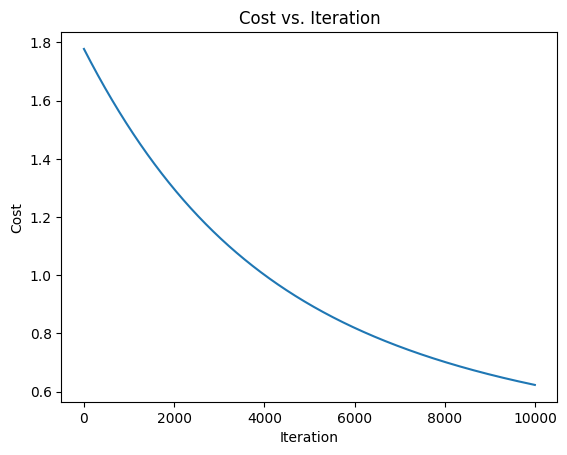

In [37]:
plt.plot(J_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost vs. Iteration")
plt.show()

In [38]:
# z=np.array([[52,0,3,136,196,0,2,169,0,0.1,2,0,3]])
# z=(z - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
# print(predict_tip(w,b,z))

In [39]:
p= predict_tip(w, b, X_train_scaled)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))
print('cost', J_history[-1])

Train Accuracy: 74.347826
cost 0.6230209475207606


In [40]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=10000)
model.fit(X_train_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [41]:
print('Train Accuracy sklearn: %f'%(model.score(X_train_scaled, y_train) * 100))
print('cost',compute_cost(X_train_scaled, y_train, model.coef_[0], model.intercept_[0]))

Train Accuracy sklearn: 81.521739
cost 0.4170766328913329


In [42]:
from sklearn.linear_model import LogisticRegressionCV
model_cv = LogisticRegressionCV(max_iter=10000)
model_cv.fit(X_train_scaled, y_train)

,Cs,10
,fit_intercept,True
,cv,None
,dual,False
,penalty,'l2'
,scoring,None
,solver,'lbfgs'
,tol,0.0001
,max_iter,10000
,class_weight,None
,n_jobs,None


In [43]:
print(model_cv.score(X_train_scaled, y_train)*100)
print(compute_cost(X_train_scaled, y_train, model_cv.coef_[0], model_cv.intercept_[0]))

80.54347826086956
0.4647860992032987


In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # pyright: ignore[reportMissingImports]
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
from tensorflow.keras.losses import BinaryCrossentropy # type: ignore
tf.config.run_functions_eagerly(True)
m,n = X_train.shape
model_tfuci = Sequential([
    Dense(128,name='layer1' ,activation='relu',
                          kernel_initializer='he_normal',
                          input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.45),

    Dense(64, name='layer2', activation='relu',
                          kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.35),

    Dense(32, name='layer3', activation='relu'),
    tf.keras.layers.Dropout(0.25),

    Dense(1, name='output_layer',activation='sigmoid')
])
#Dense - BatchNorm - ReLU - Dropout
#Dropout từ 0.45 đến 0.25 giảm dần theo từng layer(tắt ngẫu nhiên neuron khi TRAINING để tránh overfitting 45%, 35%, 25%)
model_tfuci.summary()


c:\Users\LOQ\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,185 (51.50 KB)

 Trainable params: 12,801 (50.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
   X_train, y_train, test_size=0.2,
    stratify=y_train,
    random_state=42
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0007,
    clipnorm=1.0   # chống exploding gradient
)

model_tfuci.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)
np.random.seed(1)
tf.random.set_seed(1)
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)#để dừng sớm tránh overfit

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=20,
    min_lr=1e-5
)#giảm learing_rate khi đến epoch nhất định
history = model_tfuci.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early, reduce_lr],
    verbose=1
)

loss, acc = model_tfuci.evaluate(X_test, y_test, verbose=0)
print(f" Accuracy NN  {acc*100:.2f}%")


Epoch 1/200
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.6562 - loss: 0.6457

c:\Users\LOQ\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8106 - loss: 0.4528 - val_accuracy: 0.8814 - val_loss: 0.3458 - learning_rate: 7.0000e-04
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8128 - loss: 0.4286 - val_accuracy: 0.8814 - val_loss: 0.3474 - learning_rate: 7.0000e-04
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.8191 - loss: 0.4280 - val_accuracy: 0.8729 - val_loss: 0.3496 - learning_rate: 7.0000e-04
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8277 - loss: 0.4149 - val_accuracy: 0.8729 - val_loss: 0.3504 - learning_rate: 7.0000e-04
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.8298 - loss: 0.4188 - val_accuracy: 0.8729 - val_loss: 0.3516 - learning_rate: 7.0000e-04
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.8255 - loss: 0.4172 - val_accuracy: 0.8729 - val_loss: 0.3507 - learning_rate: 7.0000e-04
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8128 - los

In [ ]:
w,b=model_tfuci.get_layer('output_layer').get_weights()
print('Weights:', w)    
print('Bias:', b)

Weights: [[-0.26558954]
 [-0.16097724]
 [ 0.18298332]
 [-0.21877581]
 [ 0.13256449]
 [ 0.16837756]
 [ 0.16571297]
 [-0.18774608]
 [-0.18249188]
 [-0.16955432]
 [-0.16857903]
 [ 0.07838015]
 [-0.35061747]
 [-0.19614652]
 [ 0.2051997 ]
 [ 0.2635844 ]
 [-0.06024268]
 [ 0.07303312]
 [ 0.29458955]
 [ 0.30783334]
 [ 0.02442101]
 [ 0.26674107]
 [-0.06095346]
 [ 0.08115398]
 [ 0.2606371 ]
 [ 0.17826034]
 [ 0.0975196 ]
 [ 0.15404409]
 [ 0.25926918]
 [ 0.09606294]
 [-0.1505992 ]
 [ 0.00726669]]
Bias: [-0.04250666]


In [ ]:

# X_train_scaled = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0) # normalization

